In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

from math import sqrt
from sklearn.metrics import mean_squared_error

from fredapi import Fred

from qreit.models.api_config import *
fred_key = fred_API

import time

import matplotlib.pyplot as plt
%matplotlib inline

/Users/marktblack/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


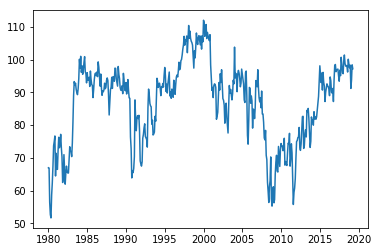

In [2]:
fred = Fred(fred_key)

UMCSENT_df = fred.get_series('UMCSENT').to_frame()
UMCSENT_df.columns = ['UMCSENT']
UMCSENT_80_df = UMCSENT_df[UMCSENT_df.index >= '1980-01']

plt.plot(UMCSENT_80_df)
plt.show()

In [3]:
UMCSENT_80_df['UMCSENT_1'] = UMCSENT_80_df.shift(-1)
UMCSENT_80_df.dropna(inplace=True)

/Users/marktblack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/marktblack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

UMCSENT_80_X_scaled = scaler.fit_transform(UMCSENT_80_df['UMCSENT'].to_frame())
UMCSENT_80_y_scaled = scaler.fit_transform(UMCSENT_80_df['UMCSENT_1'].to_frame())

In [5]:
test = int(len(UMCSENT_80_X_scaled)*0.90)

X_train_scaled = UMCSENT_80_X_scaled[:test]
y_train_scaled = UMCSENT_80_y_scaled[:test]
y_train = UMCSENT_80_df['UMCSENT_1'][:test]

X_test_scaled = UMCSENT_80_X_scaled[test:]
y_test_scaled = UMCSENT_80_y_scaled[test:]
y_test = UMCSENT_80_df['UMCSENT_1'][test:]

In [6]:
X_train = np.reshape(X_train_scaled, 
                     (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# y_train = np.reshape(y_train_scaled, 
#                      (y_train_scaled.shape[0], 1, y_train_scaled.shape[1]))

X_test = np.reshape(X_test_scaled, 
                    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
# y_test = np.reshape(y_test_scaled, 
#                     (y_test_scaled.shape[0], 1, y_test_scaled.shape[1]))

In [7]:
n_lookback = 1

In [8]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(n_lookback,X_train.shape[2]), 
#                activation='relu', return_sequences=True))
# # model.add(Dropout(0.2))
# # model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())

# model.add(LSTM(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation='softmax'))

# model.compile(loss='mae', optimizer='RMSprop')

In [9]:
model = Sequential()
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.2, return_sequences=True,
              input_shape=(n_lookback, X_train.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(X_train.shape[2]))

# opt = tf.keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
def rnn_hyperparameter_tune(X_train, y_train_scaled, n_epochs, batchSize):
    model.fit(X_train, 
              y_train_scaled, 
              epochs=n_epochs,
              batch_size=batchSize, 
              verbose=0,
              shuffle=False)
    
    yhat_scale = model.predict(X_test)
    
    y_hat_inv_scaled = scaler.inverse_transform(yhat_scale)
    temp_root_sq_mu_err = sqrt(mean_squared_error(y_test.values, y_hat_inv_scaled))
    temp_root_sq_mu_err_per = round(sqrt(mean_squared_error(y_test.values, y_hat_inv_scaled))/y_test.values.mean()*100,4)
    
    print(f'# of Epochs, Batch Size: {n_epochs}, {batchSize}')
    print('Test RMSE: %.3f' % temp_root_sq_mu_err)
    print(f'RMSE %: {temp_root_sq_mu_err_per}%\n')
    
    return temp_root_sq_mu_err

In [11]:
root_sq_mu_err_ls = []

for epochs in range(100, 500, 100):
    root_sq_mu_err_ls.append(rnn_hyperparameter_tune(X_train, y_train_scaled, epochs, 40))

Instructions for updating:
Use tf.cast instead.
# of Epochs, Batch Size: 100, 40
Test RMSE: 3.051
RMSE %: 3.2136%

# of Epochs, Batch Size: 200, 40
Test RMSE: 2.841
RMSE %: 2.9923%

# of Epochs, Batch Size: 300, 40
Test RMSE: 2.853
RMSE %: 3.0047%

# of Epochs, Batch Size: 400, 40
Test RMSE: 2.882
RMSE %: 3.0357%



In [12]:
N_EPOCHS = 200
batchSize = 40

model.fit(X_train, 
          y_train_scaled, 
          epochs=N_EPOCHS,
          batch_size=batchSize, 
          verbose=0,
          shuffle=False)


In [13]:
tensorboard = TensorBoard(log_dir="logs/{}".format('test'))

In [14]:
yhat_scale = model.predict(X_test)
# yhat_scale

In [15]:
inv_yhat = np.concatenate((X_test_scaled, yhat_scale), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [16]:
y_hat_inv_scaled = scaler.inverse_transform(yhat_scale)
preds_actuals_df = pd.DataFrame(y_test.values, 
                                y_hat_inv_scaled.flatten()).reset_index(drop=False)
preds_actuals_df.columns = ['preds', 'actual']
preds_actuals_df.assign(diff=preds_actuals_df.preds-preds_actuals_df.actual)


,preds,actual,diff
0,94.679970,90.7,3.979970
1,91.177277,96.1,-4.922723
2,94.842216,93.1,1.742216
3,92.638489,91.9,0.738489
4,91.883652,87.2,4.683652
5,87.804703,90.0,-2.195297
6,90.761169,91.3,-0.538831
7,91.525932,92.6,-1.074068
8,92.316650,92.0,0.316650
9,91.944382,91.7,0.244382


In [17]:
y_hat_inv_scaled

array([[94.67997 ],
       [91.17728 ],
       [94.84222 ],
       [92.63849 ],
       [91.88365 ],
       [87.8047  ],
       [90.76117 ],
       [91.52593 ],
       [92.31665 ],
       [91.94438 ],
       [91.7632  ],
       [91.35068 ],
       [89.894844],
       [93.75255 ],
       [92.90447 ],
       [90.76117 ],
       [90.59524 ],
       [91.46728 ],
       [87.8047  ],
       [93.10927 ],
       [96.66494 ],
       [96.9408  ],
       [95.006584],
       [95.51205 ],
       [95.59803 ],
       [95.68449 ],
       [93.976906],
       [92.837234],
       [95.42655 ],
       [94.05281 ],
       [99.043304],
       [96.9408  ],
       [94.67997 ],
       [94.51988 ],
       [98.073265],
       [99.73076 ],
       [97.21983 ],
       [96.48292 ],
       [96.66494 ],
       [96.392494],
       [94.92413 ],
       [98.45906 ],
       [97.03348 ],
       [96.034966],
       [96.75653 ],
       [91.46728 ],
       [93.10927 ],
       [96.84849 ]], dtype=float32)

In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print('Test RMSE: %.3f' % sqrt(mean_squared_error(y_test.values,
                                                 y_hat_inv_scaled)))
print(f'RMSE %: {round(sqrt(mean_squared_error(y_test.values, y_hat_inv_scaled))/y_test.values.mean()*100,4)}%')

Test RMSE: 2.910
RMSE %: 3.0655%


### beer

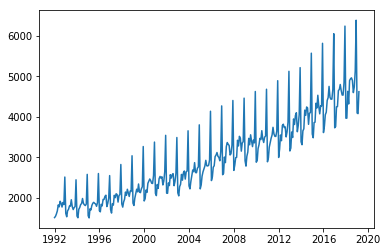

In [19]:
beer_df = fred.get_series('MRTSSM4453USN').to_frame()
beer_df.columns = ['beer']
beer_df = beer_df[beer_df.index >= '1980-01']
beer_df['beer_1'] = beer_df.shift(-1)
plt.plot(beer_df['beer'])
plt.show()

In [20]:
beer_UMCSENT_df = pd.merge(beer_df, UMCSENT_80_df, 
                            how='left', right_index=True, left_index=True).dropna()

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

beer_UMCSENT_X_scaled = scaler.fit_transform(beer_UMCSENT_df[['beer', 'UMCSENT']])
beer_UMCSENT_y_scaled = scaler.fit_transform(beer_UMCSENT_df[['UMCSENT_1']])

In [22]:
test = int(len(beer_UMCSENT_X_scaled)*0.95)

X_train_scaled = beer_UMCSENT_X_scaled[:test]
y_train_scaled = beer_UMCSENT_y_scaled[:test]
y_train = beer_UMCSENT_df[['beer_1','UMCSENT_1']][:test]

X_test_scaled = beer_UMCSENT_X_scaled[test:]
y_test_scaled = beer_UMCSENT_y_scaled[test:]
y_test = beer_UMCSENT_df[['UMCSENT_1']][test:]

In [23]:
X_train = np.reshape(X_train_scaled, 
                     (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

X_test = np.reshape(X_test_scaled, 
                    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [24]:
model = Sequential()
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.2, return_sequences=True,
              input_shape=(n_lookback, X_train.shape[2]),  activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(X_train.shape[1]))

# opt = tf.keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])

In [25]:
N_EPOCHS =100
batchSize = 40

model.fit(X_train, 
          y_train_scaled, 
          epochs=N_EPOCHS,
          batch_size=batchSize, 
          verbose=1,
          shuffle=False)

Epoch 1/100
309/309 [==============================] - 1s 5ms/sample - loss: 1.0163 - mean_absolute_error: 0.8067
Epoch 2/100
309/309 [==============================] - 0s 131us/sample - loss: 1.0048 - mean_absolute_error: 0.8017
Epoch 3/100
309/309 [==============================] - 0s 126us/sample - loss: 0.9944 - mean_absolute_error: 0.7974
Epoch 4/100
309/309 [==============================] - 0s 122us/sample - loss: 0.9822 - mean_absolute_error: 0.7924
Epoch 5/100
309/309 [==============================] - 0s 126us/sample - loss: 0.9722 - mean_absolute_error: 0.7875
Epoch 6/100
309/309 [==============================] - 0s 113us/sample - loss: 0.9603 - mean_absolute_error: 0.7820
Epoch 7/100
309/309 [==============================] - 0s 115us/sample - loss: 0.9410 - mean_absolute_error: 0.7745
Epoch 8/100
309/309 [==============================] - 0s 110us/sample - loss: 0.9309 - mean_absolute_error: 0.7673
Epoch 9/100
309/309 [==============================] - 0s 117us/sample - l

309/309 [==============================] - 0s 102us/sample - loss: 0.1592 - mean_absolute_error: 0.3057
Epoch 72/100
309/309 [==============================] - 0s 88us/sample - loss: 0.1847 - mean_absolute_error: 0.3096
Epoch 73/100
309/309 [==============================] - 0s 102us/sample - loss: 0.1893 - mean_absolute_error: 0.3202
Epoch 74/100
309/309 [==============================] - 0s 98us/sample - loss: 0.2076 - mean_absolute_error: 0.3245
Epoch 75/100
309/309 [==============================] - 0s 103us/sample - loss: 0.2175 - mean_absolute_error: 0.3396
Epoch 76/100
309/309 [==============================] - 0s 99us/sample - loss: 0.1495 - mean_absolute_error: 0.2901
Epoch 77/100
309/309 [==============================] - 0s 98us/sample - loss: 0.2283 - mean_absolute_error: 0.3382
Epoch 78/100
309/309 [==============================] - 0s 102us/sample - loss: 0.1981 - mean_absolute_error: 0.3195
Epoch 79/100
309/309 [==============================] - 0s 103us/sample - loss: 0

In [26]:
yhat_scale = model.predict(X_test)
# yhat_scale

In [27]:
# inv_yhat = np.concatenate((X_test_scaled, yhat_scale), axis=1)
inv_yhat = scaler.inverse_transform(yhat_scale)

In [28]:
y_hat_inv_scaled = scaler.inverse_transform(yhat_scale)
preds_df = pd.DataFrame(y_hat_inv_scaled, columns=['UMCSENT_preds'])

In [29]:
# y_test = y_test.assign(beer_preds=preds_df['beer_preds'].values)
y_test['UMCSENT_preds'] = preds_df['UMCSENT_preds'].values

# beer_preds_actual_df = y_test[['beer_1', 'beer_preds']]
UMCSENT_preds_actual_df = y_test[['UMCSENT_1', 'UMCSENT_preds']]

# beer_preds_actual_df = beer_preds_actual_df.assign(beer_diff=(beer_preds_actual_df.beer_preds-\
#                                                   beer_preds_actual_df.beer_1))
UMCSENT_preds_actual_df = UMCSENT_preds_actual_df.assign(UMCSENT_diff=(UMCSENT_preds_actual_df.UMCSENT_preds-\
                                                          UMCSENT_preds_actual_df.UMCSENT_1))


In [30]:
# print('Test RMSE: %.3f' % sqrt(mean_squared_error(beer_preds_actual_df.beer_1,
#                                                  beer_preds_actual_df.beer_preds)))
# print(f'RMSE %: {round(sqrt(mean_squared_error(beer_preds_actual_df.beer_1, beer_preds_actual_df.beer_preds))/beer_preds_actual_df.beer_1.mean()*100,4)}%')

In [31]:
# plt.figure(figsize=(12,5))
# plt.plot(beer_preds_actual_df.beer_1, label='actual')
# plt.plot(beer_preds_actual_df.beer_preds, label='pred')
# plt.title(f'Beer')
# plt.legend()
# plt.show()

In [32]:
print('Test RMSE: %.3f' % sqrt(mean_squared_error(UMCSENT_preds_actual_df.UMCSENT_1,
                                                 UMCSENT_preds_actual_df.UMCSENT_preds)))
print(f'RMSE %: {round(sqrt(mean_squared_error(UMCSENT_preds_actual_df.UMCSENT_1, UMCSENT_preds_actual_df.UMCSENT_preds))/UMCSENT_preds_actual_df.UMCSENT_1.mean()*100,4)}%')


Test RMSE: 3.327
RMSE %: 3.411%


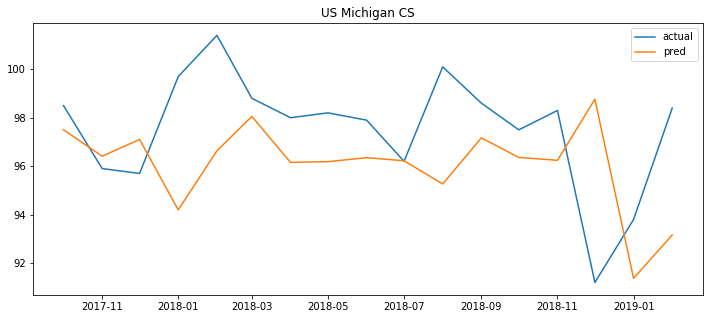

In [33]:
plt.figure(figsize=(12,5))
plt.plot(UMCSENT_preds_actual_df.UMCSENT_1, label='actual')
plt.plot(UMCSENT_preds_actual_df.UMCSENT_preds, label='pred')
plt.title(f'US Michigan CS')
plt.legend()
plt.show()

### Keras

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [35]:
def keras_lstm(x_train, y_train_scaled, X_test, 
               N_EPOCHS, batchSize, neuron_1):
    model = Sequential()
    model.add(LSTM(neuron_1, 
                   batch_input_shape=(batchSize, x_train.shape[1], x_train.shape[2]), 
                   stateful=True, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(LSTM(neuron_2, activation='relu'))
#     model.add(Dropout(0.1))    
    model.add(Dense(X_train.shape[2]))
    
    model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])
    
    model.fit(X_train, y_train_scaled, 
              epochs=N_EPOCHS,
              batch_size=batchSize, 
              verbose=1,
              shuffle=False)
    yhat_scale = model.predict(X_test, batch_size=batchSize)
    return yhat_scale


In [36]:
# yhat_scale_preds = keras_lstm(X_train, y_train_scaled, X_test, 50, 1, 1, )

In [37]:
def inverse_scale(inv_preds):
    return scaler.inverse_transform(inv_preds)

In [38]:
# inverse_scale(yhat_scale_preds)

## LSTM model

In [43]:
from qreit.models.lstm.data_processor import *
from qreit.models.lstm.model import *

default_configs = default_configs

In [44]:
data = DataLoader(beer_UMCSENT_df, 0.85, ['beer', 'UMCSENT'])

model = Model()
model.build_model()
x, y = data.get_train_data(3, True)

[Model] Model Compiled
Time taken: 0:00:00.535355


In [45]:
model.train_generator(data,
                     steps_per_epoch = math.ceil((data.len_train - \
                                                  default_configs['data']['sequence_length']) / \
                                                  default_configs['training']['batch_size']))


[Model] Training Started
[Model] 2 epochs, 32 batch size, 9 batches per epoch
Epoch 1/2


ValueError: Error when checking input: expected lstm_4_input to have shape (1, 2) but got array with shape (2, 2)

In [ ]:
x_test, y_test = data.get_test_data(seq_len=3,
                                     normalise=True)

In [ ]:
predictions = model.predict_point_by_point(x_test)

In [ ]:
i_split = int(len(beer_UMCSENT_df)*0.85)
train_test = beer_UMCSENT_df.get(['beer', 'UMCSENT']).values[:i_split]
test_test = beer_UMCSENT_df.get(['beer', 'UMCSENT']).values[i_split:]

len_test = len(test_test)

In [ ]:
seq_len = 12
data_windows = []
for i in range(len_test - seq_len):
    data_windows.append(test_test[i:i+seq_len])

In [ ]:
def normalise_windows(window_data, single_window=False):
    '''Normalise window with a base value of zero'''
    normalised_data = []
    window_data = [window_data] if single_window else window_data
    for window in window_data:
        normalised_window = []
        for col_i in range(window.shape[1]):
            normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
            normalised_window.append(normalised_col)
        normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
        normalised_data.append(normalised_window)
    return np.array(normalised_data)

In [ ]:
data_windows = np.array(data_windows).astype(float)
data_windows = normalise_windows(data_windows, single_window=False)

In [ ]:
x = data_windows[:, :-1]
y = data_windows[:, -1, [0]]

In [ ]:
y = data_windows[:, -1, [0]]

In [ ]:
y.shape